In [5]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
import numpy as np
from scipy.fftpack import dctn, idctn
from tqdm import tqdm
import pandas as pd
import pywt

sys.path.append(str(Path("..").resolve()))
from src import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Video Fusion With Discrete Cosine Transform (DCT) [Astro]
Can we augment a denoiser output using a sliding window on the raw footage and DCT video fusion?

This can be used to **reduce the number of training steps for deep-learning models**, which are known to be expensive to train. This is the case with DeepCAD-RT, which uses a 3D UNet.

In [32]:
patch_xy = 512
frames_per_patch = 512
window = 512

In [33]:
astro_x_path = DATASETS["oabf_astro"].dir / "x.tiff"
astro_y_path = DATASETS["oabf_astro"].dir / "y.tiff"
astro_x, astro_y = (Recording(_, max_frames=frames_per_patch*2) for _ in [astro_x_path, astro_y_path])

In [34]:
patch = astro_x.np[frames_per_patch : frames_per_patch * 2, :patch_xy, :patch_xy]
patch_deepcad = astro_y.np[frames_per_patch : frames_per_patch * 2, :patch_xy, :patch_xy]
patch_mean = np.empty_like(patch)
for i in tqdm(range(patch.shape[0])):
    patch_mean[i] = astro_x.avg(frames_per_patch + i, window=window)[:patch_xy, :patch_xy]

100%|██████████| 512/512 [00:43<00:00, 11.82it/s]


In [82]:
def merge_wavelet(hf_xy, hf_z, wavelet="db2", level=2):
    coeffs1 = pywt.dwtn(hf_xy, wavelet=wavelet, axes=(0, 1, 2))
    coeffs2 = pywt.dwtn(hf_z, wavelet=wavelet, axes=(0, 1, 2))

    fused_coeff = {}
    for key in coeffs1:
        if key == "aaa":
            fused_coeff[key] = coeffs1[key]
        else:
            fused_coeff[key] = coeffs2[key]

    return fused_coeff, pywt.idwtn(fused_coeff, wavelet=wavelet, axes=(0, 1, 2))

In [83]:
wavelet="haar"
level=2

DeepCAD frames


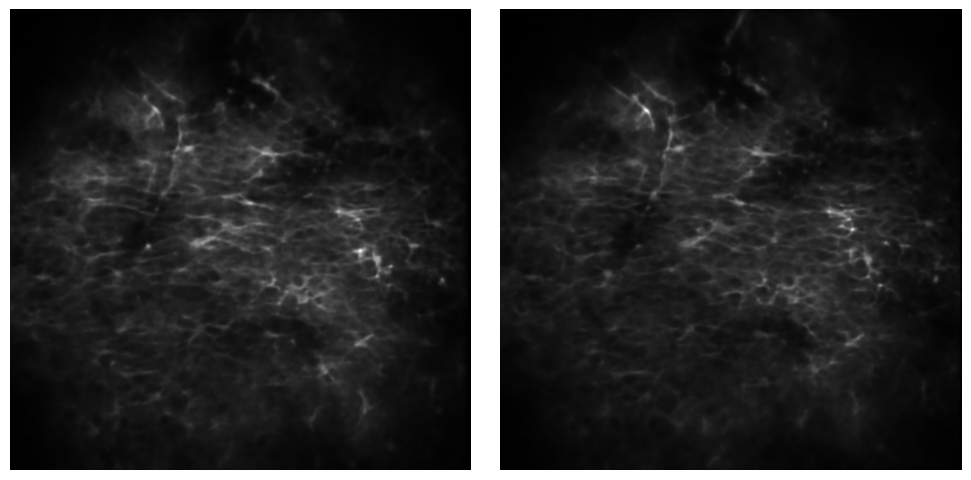

Fused frames


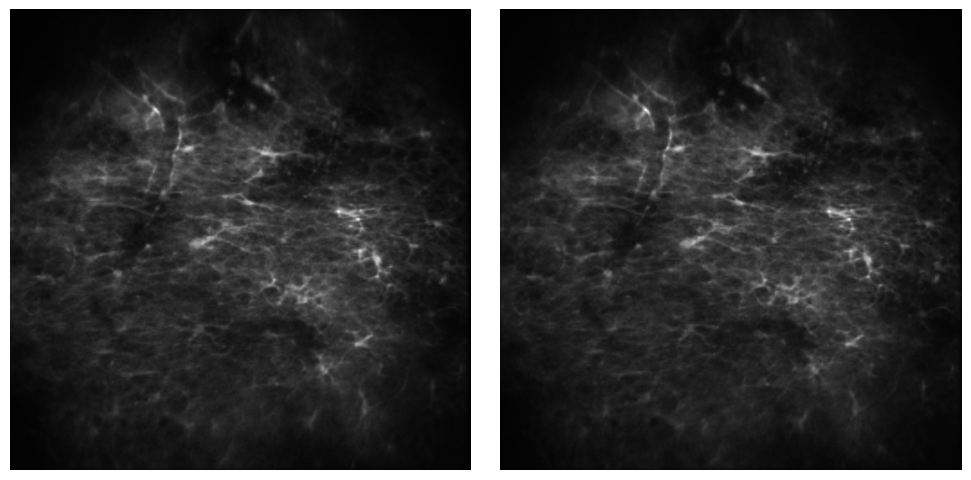

Averaged frames


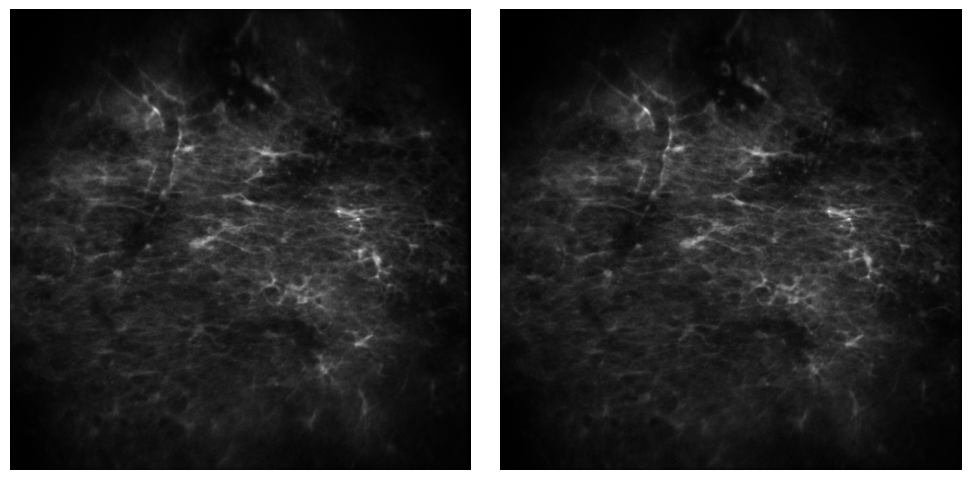

In [84]:
# 1 min for 512x512x512
fused_coeff, fused = merge_wavelet(patch_mean, patch_deepcad)
cprint("blue:DeepCAD frames")
imshow([_ for _ in patch_deepcad[::256]], cmap="grey", size=5, cols=2)
cprint("yellow:Fused frames")
imshow([_ for _ in fused[::256]], cmap="grey", size=5, cols=2)
cprint("red:Averaged frames")
imshow([_ for _ in patch_mean[::256]], cmap="grey", size=5, cols=2)

In [69]:
patch_deepcad_wavelet = pywt.dwtn(patch_deepcad, wavelet="haar", axes=(0, 1, 2))
patch_mean_wavelet = pywt.dwtn(patch_mean, wavelet="haar", axes=(0, 1, 2))

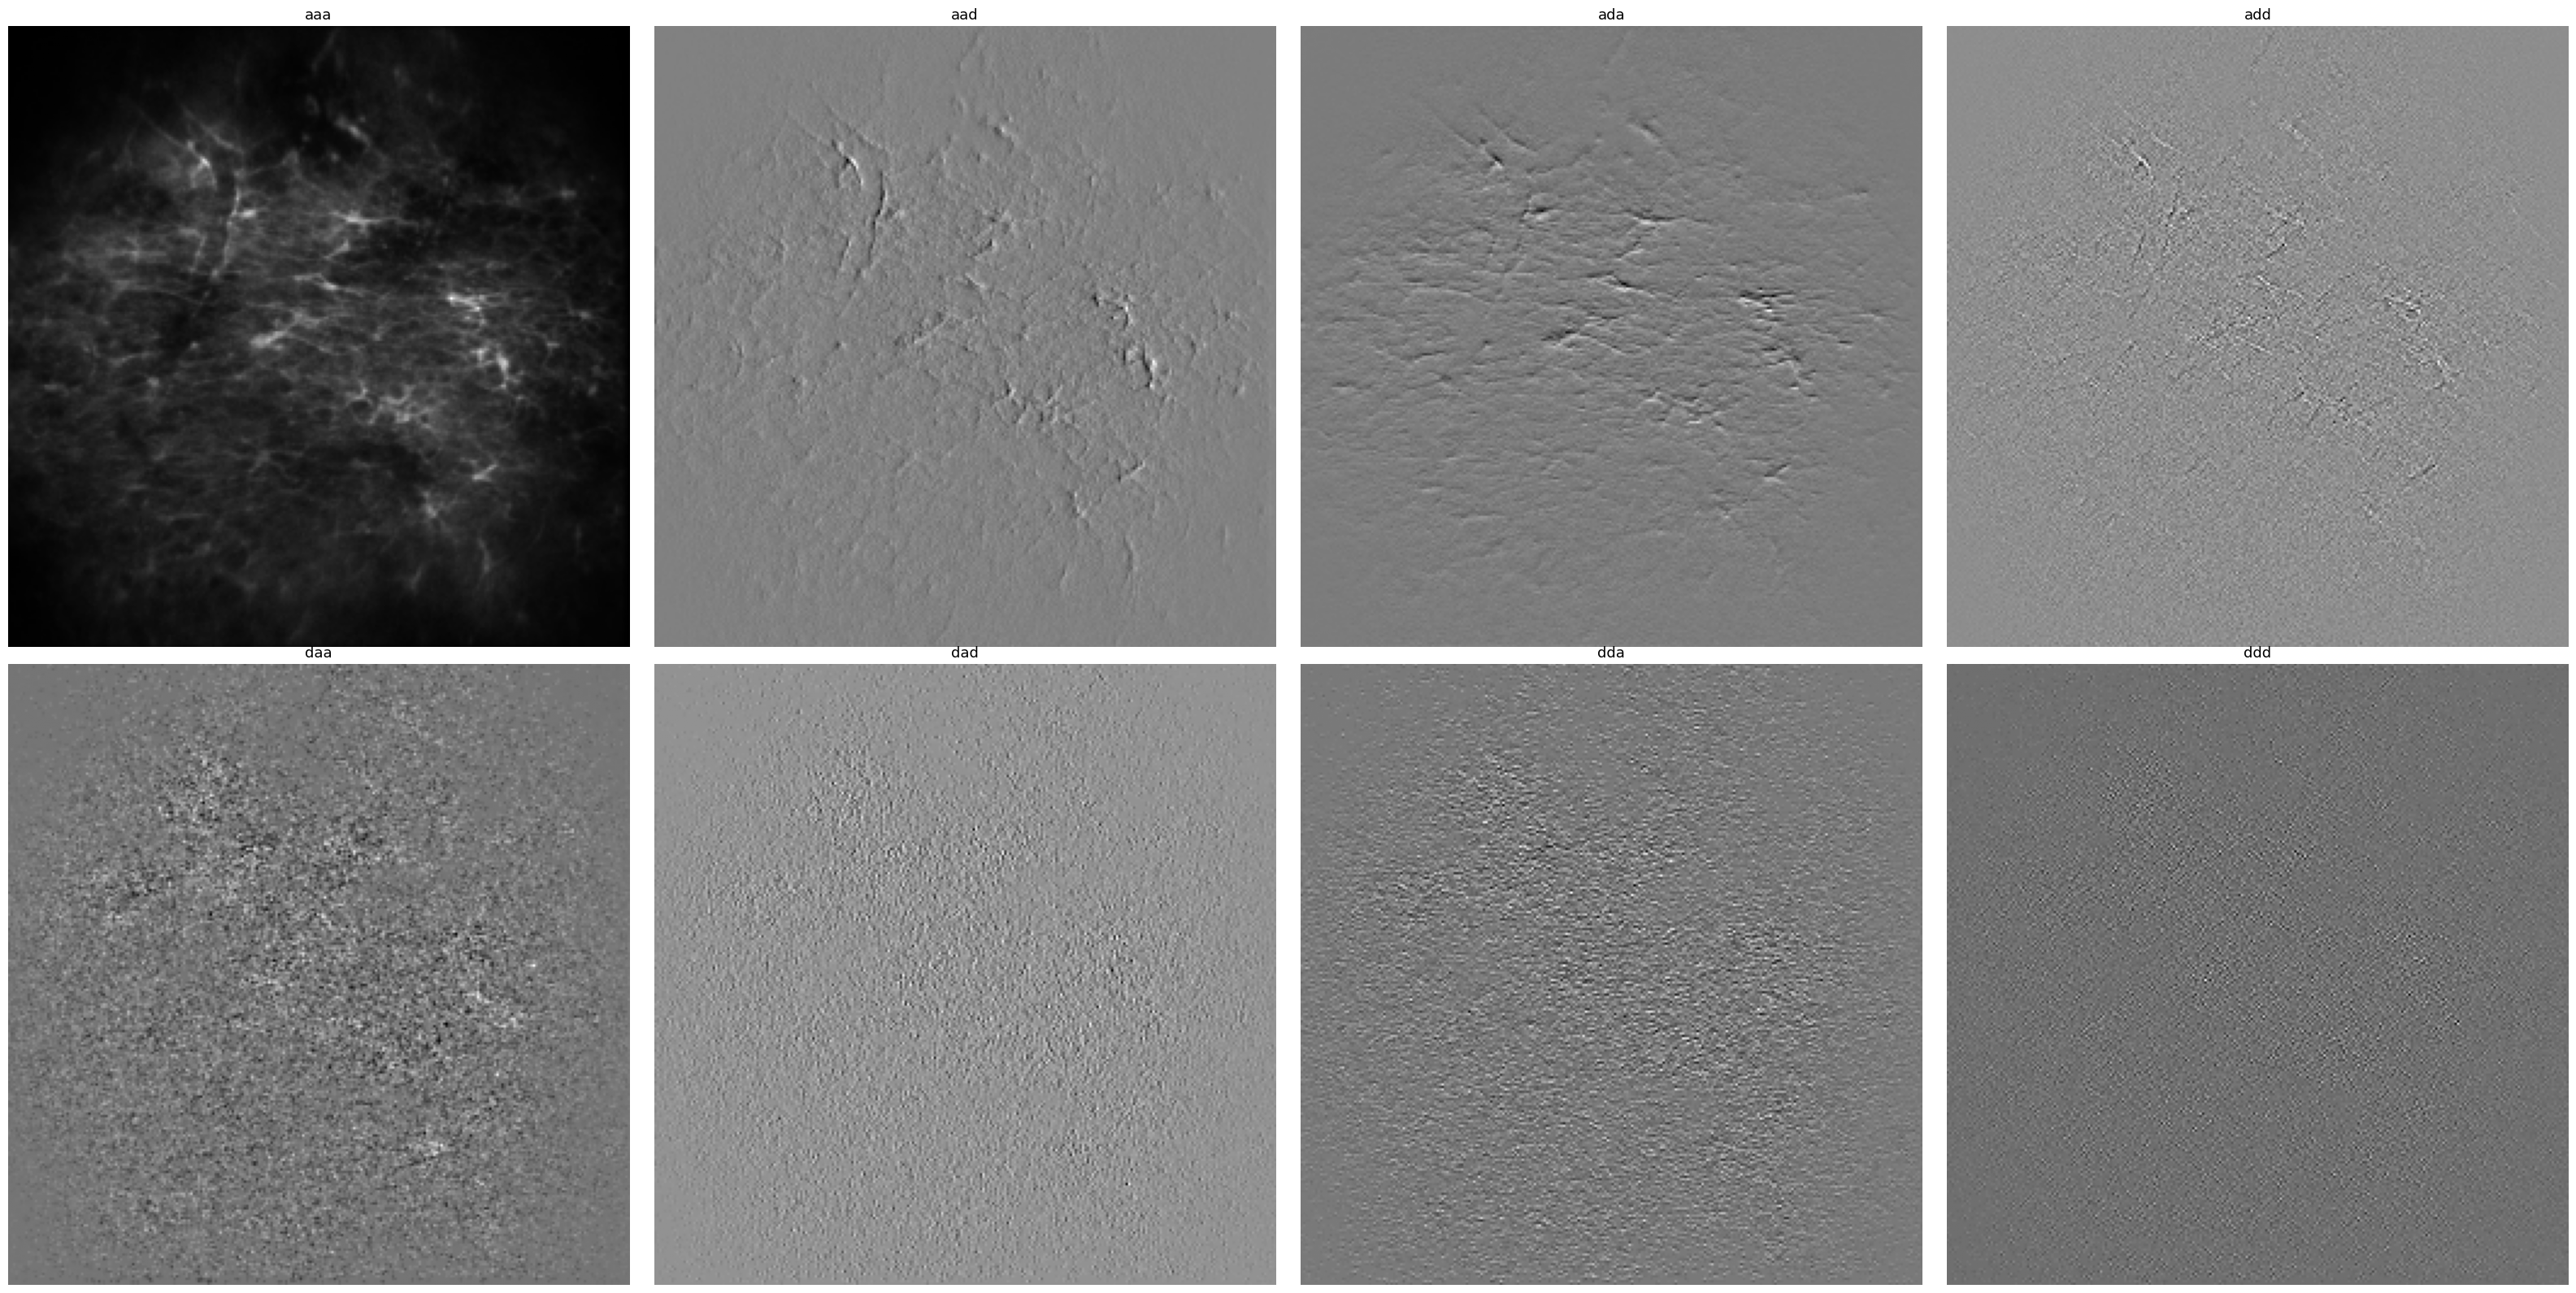

In [70]:
imshow({_: patch_mean_wavelet[_][0] for _ in patch_mean_wavelet.keys()}, cmap="grey", size=8, cols=4)

Combine deepCAD with self


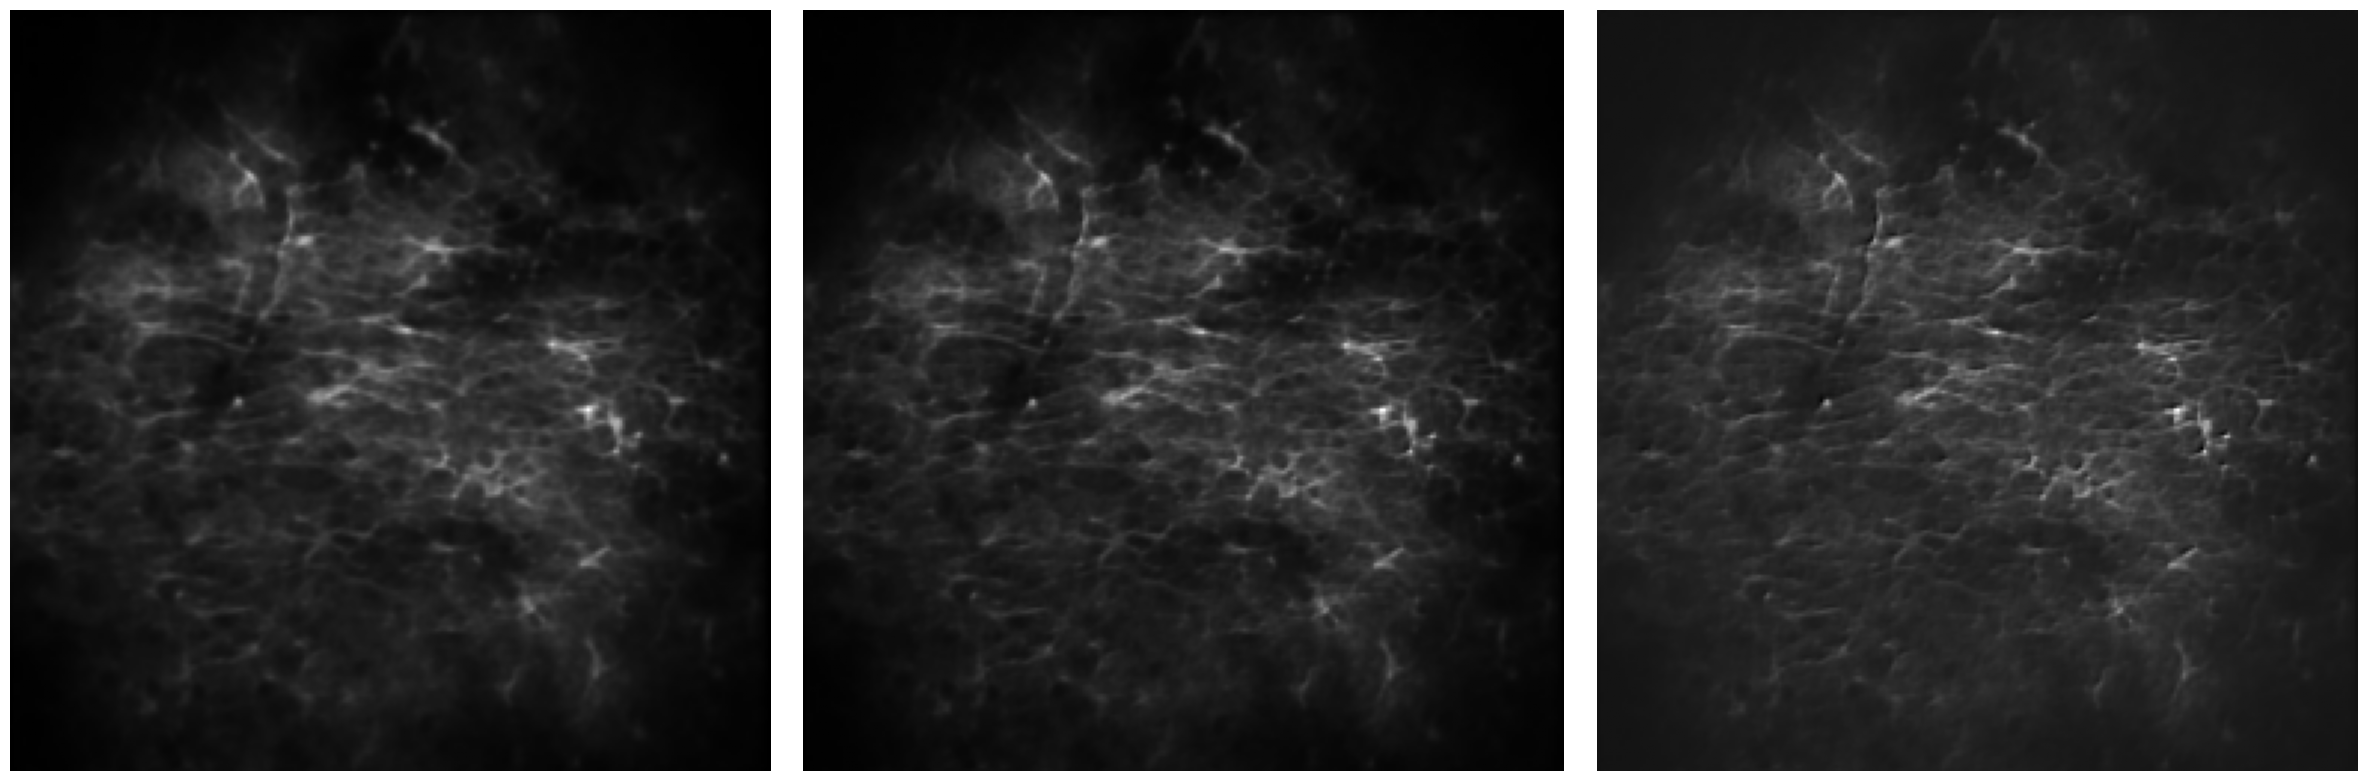

Combine deepCAD with averaged and self


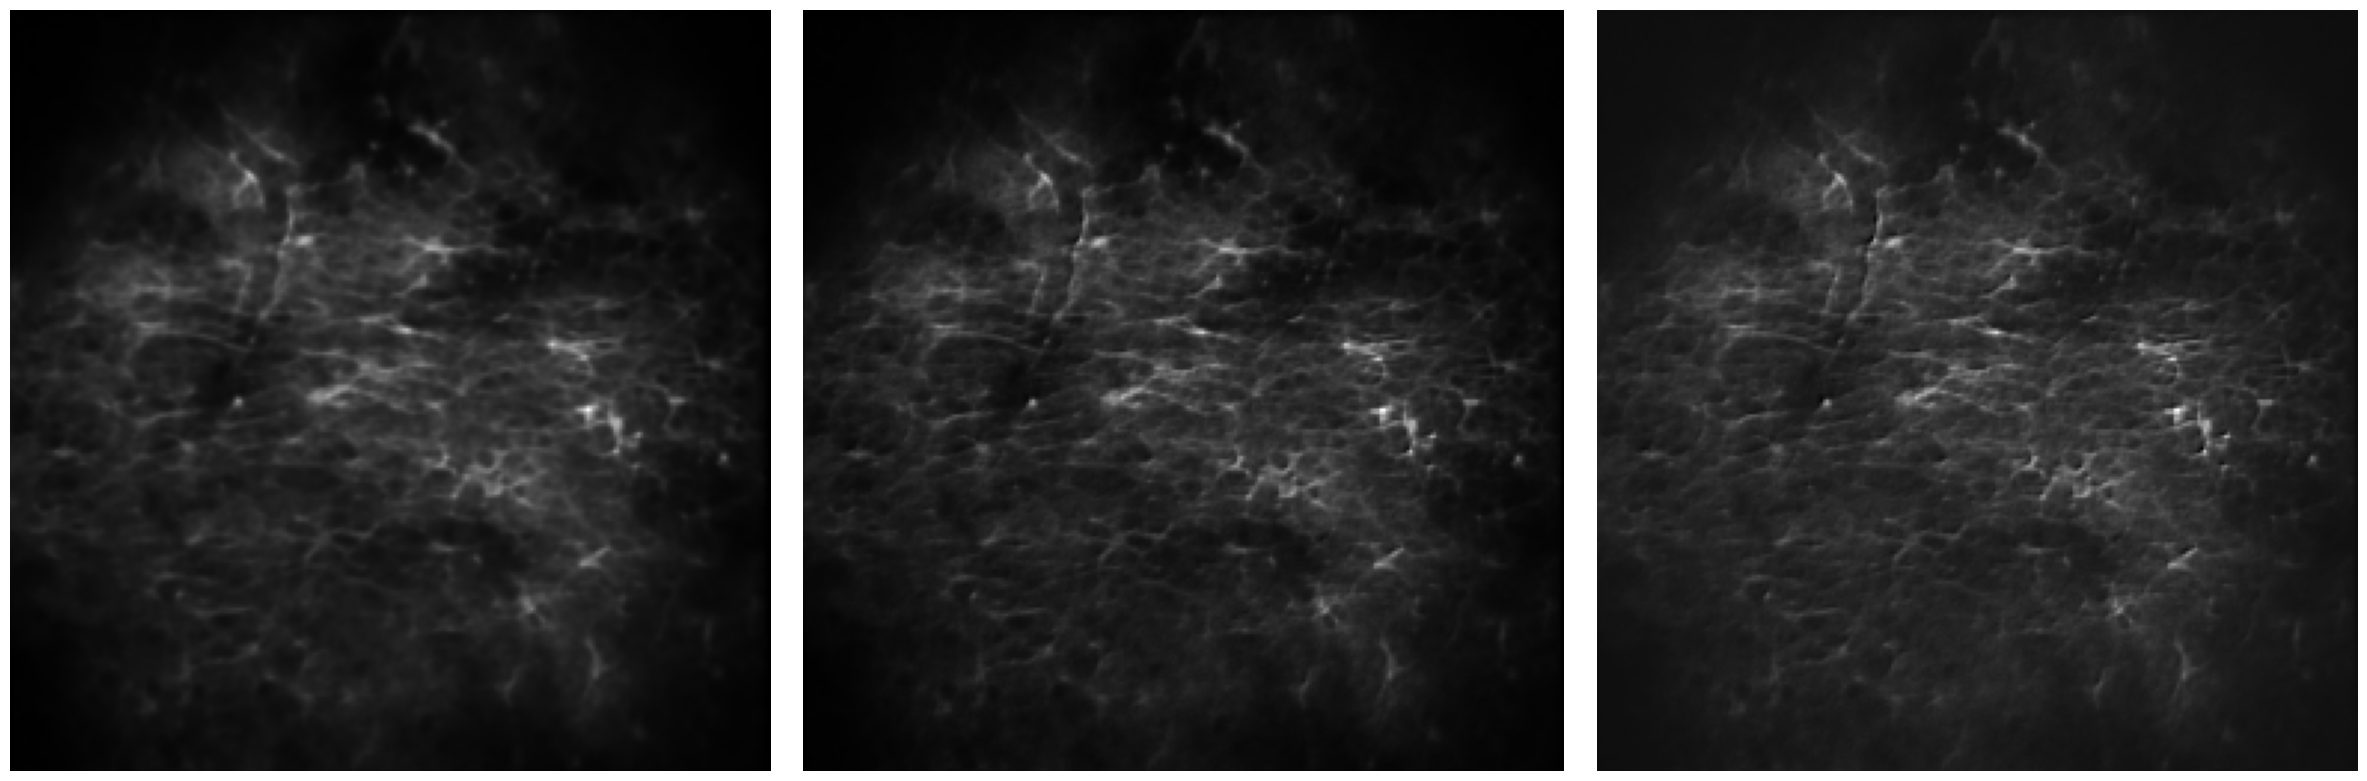

Combine deepCAD with averaged


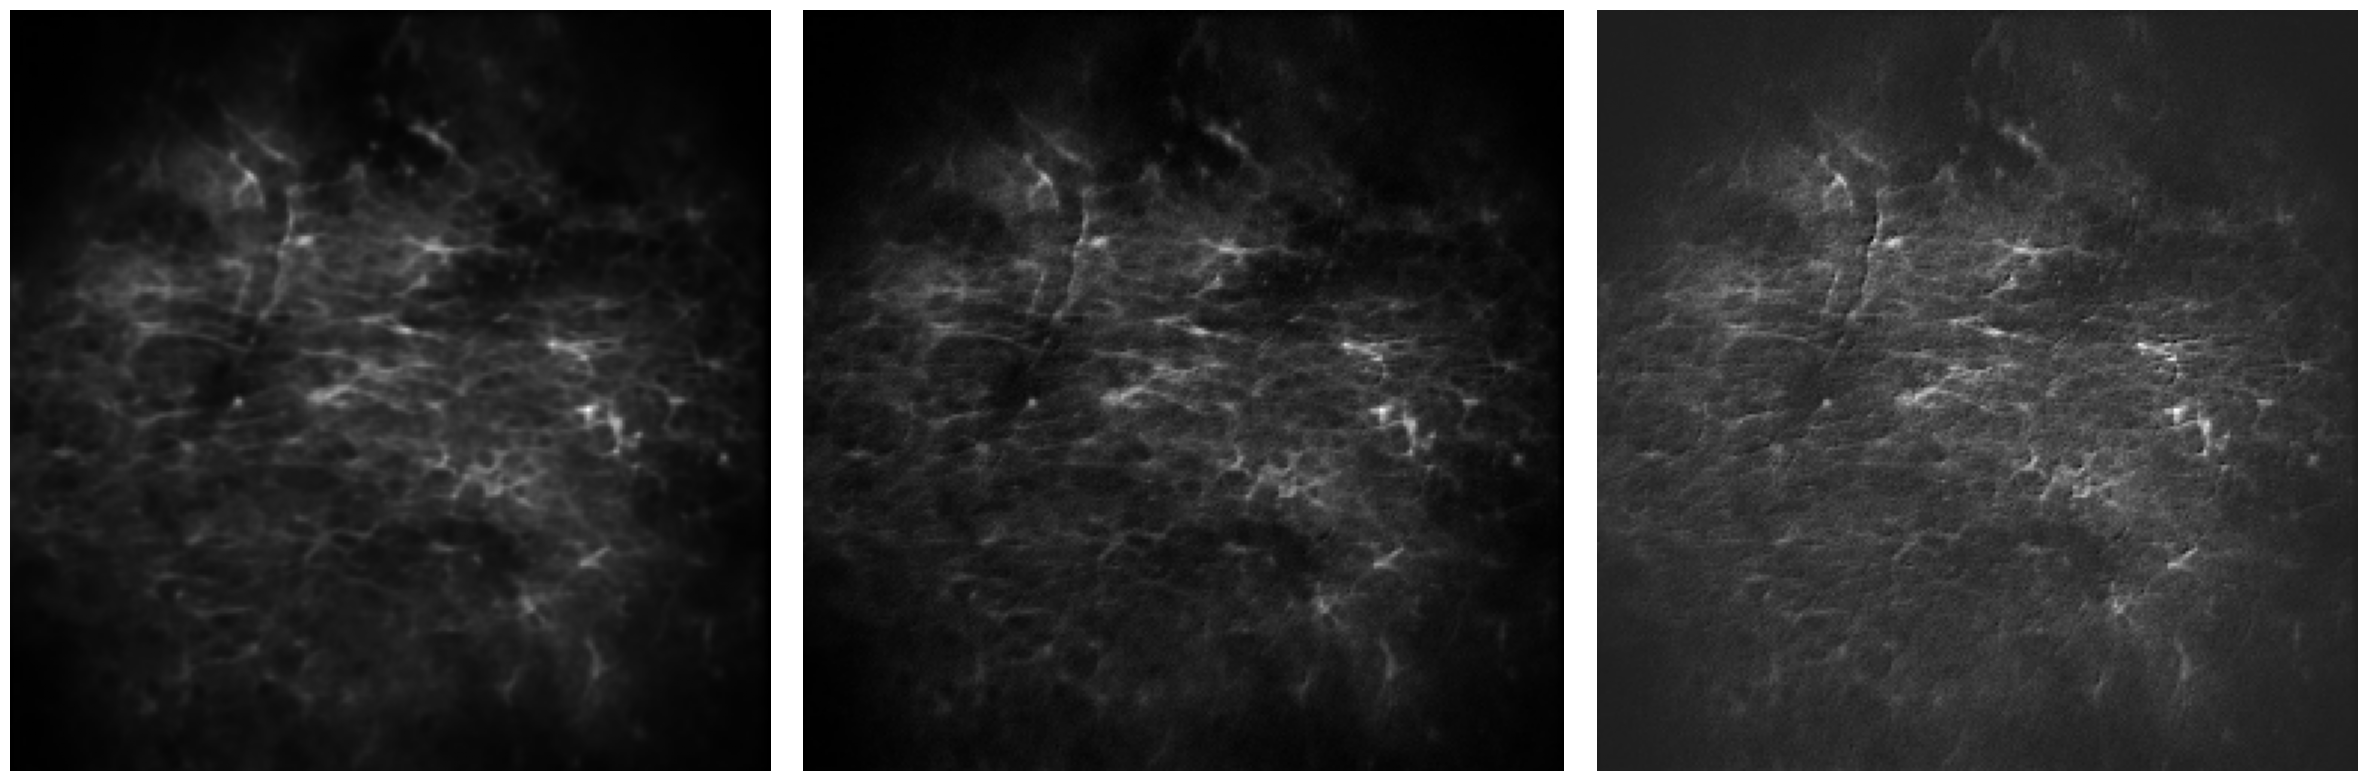

In [80]:
lf = patch_deepcad_wavelet["aaa"][0]
hf1 = patch_deepcad_wavelet["aad"][0] + patch_deepcad_wavelet["ada"][0] + patch_deepcad_wavelet["add"][0]
hf2 = patch_mean_wavelet["aad"][0] + patch_mean_wavelet["ada"][0] + patch_mean_wavelet["add"][0]
cprint("green:Combine deepCAD with self")
imshow([lf + _ * hf1 for _ in [0, 2, 4]], size=8)
cprint("green:Combine deepCAD with averaged and self")
imshow([lf + _ * (hf1*.75 + hf2*.25) for _ in [0, 2.75, 4]], size=8)
cprint("green:Combine deepCAD with averaged")
imshow([lf + _ * hf2 for _ in [0, 2, 4]], size=8)

In [11]:
Recording(fused).render(f"astro_wavelet_fused_w{window}_{wavelet}_l{level}.mp4")